# CT Scans 3D visualisation:

In [11]:
import numpy as np
import pandas as pd
import pydicom  as dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

In [27]:
import os
import pydicom

def count_slices_in_patient_folders(base_folder):
    """
    Counts the number of slices for each patient in the base folder.

    Args:
        base_folder (str): Path to the folder containing patient folders.

    Returns:
        dict: A dictionary with patient folder names as keys and slice counts as values.
    """
    patient_slice_counts = {}
    
    # Loop through each patient folder
    for patient_folder in os.listdir(base_folder):
        patient_path = os.path.join(base_folder, patient_folder)
        
        if os.path.isdir(patient_path):  # Check if it's a folder
            slice_count = 0
            
            # Count DICOM files in the patient folder
            for file_name in os.listdir(patient_path):
                file_path = os.path.join(patient_path, file_name)
                
                try:
                    # Validate if the file is a DICOM file
                    ds = pydicom.dcmread(file_path, stop_before_pixels=True)
                    slice_count += 1
                except Exception:
                    continue
            
            patient_slice_counts[patient_folder] = slice_count
    
    return patient_slice_counts

# Path to the sample_images folder
base_folder_path = "sample_images"

# Get slice counts
slice_counts = count_slices_in_patient_folders(base_folder_path)

# Print the results
for patient, count in slice_counts.items():
    print(f"Patient '{patient}' has {count} slices.")

Patient '00cba091fa4ad62cc3200a657aeb957e' has 110 slices.
Patient '00edff4f51a893d80dae2d42a7f45ad1' has 74 slices.
Patient '0a099f2549429d29b32f349e95fb2244' has 103 slices.
Patient '0a0c32c9e08cc2ea76a71649de56be6d' has 115 slices.
Patient '0a38e7597ca26f9374f8ea2770ba870d' has 57 slices.
Patient '0acbebb8d463b4b9ca88cf38431aac69' has 106 slices.
Patient '0b20184e0cd497028bdd155d9fb42dc9' has 196 slices.
Patient '0bd0e3056cbf23a1cb7f0f0b18446068' has 91 slices.
Patient '0c0de3749d4fe175b7a5098b060982a1' has 81 slices.
Patient '0c37613214faddf8701ca41e6d43f56e' has 141 slices.
Patient '0c59313f52304e25d5a7dcf9877633b1' has 139 slices.
Patient '0c60f4b87afcb3e2dfa65abbbf3ef2f9' has 114 slices.
Patient '0c98fcb55e3f36d0c2b6507f62f4c5f1' has 112 slices.
Patient '0c9d8314f9c69840e25febabb1229fa4' has 109 slices.
Patient '0ca943d821204ceb089510f836a367fd' has 102 slices.
Patient '0d06d764d3c07572074d468b4cff954f' has 136 slices.
Patient '0d19f1c627df49eb223771c28548350e' has 109 slices.
P

In [4]:
from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [5]:
INPUT_FOLDER = 'sample_images/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

In [13]:
def load_scan(path):
    slices = [dicom.dcmread(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key=lambda x: float(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness

    return slices

In [7]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16),
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0

    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):

        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope

        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)

        image[slice_number] += np.int16(intercept)

    return np.array(image, dtype=np.int16)

Text(0, 0.5, 'Frequency')

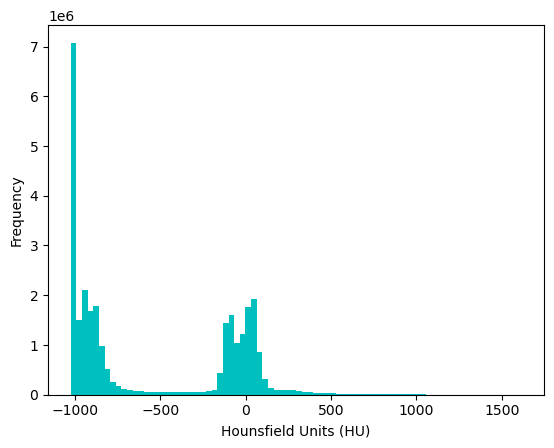

In [ ]:
#show first patient data

first_patient = load_scan(INPUT_FOLDER + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

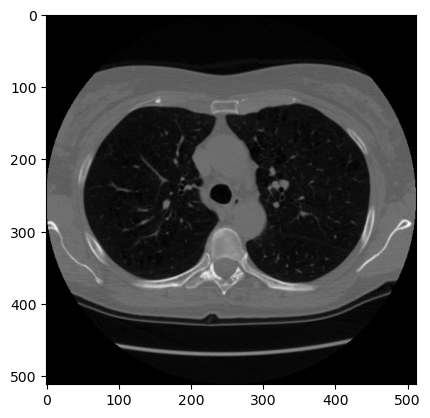

In [15]:
# Show some slice in the middle
plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
plt.show()

In [18]:
import numpy as np
import scipy.ndimage

def resample(image, scan, new_spacing=[1, 1, 1]):
    # Convert PixelSpacing from MultiValue to a list
    pixel_spacing = list(scan[0].PixelSpacing)  # Explicitly convert to a list
    # Determine current pixel spacing
    spacing = np.array([scan[0].SliceThickness] + pixel_spacing, dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape).astype(int)  # Ensure integer shape
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor

    # Resample the image using the calculated resize factor
    image = scipy.ndimage.zoom(image, real_resize_factor, mode='nearest')

    return image, new_spacing

In [19]:
pix_resampled, spacing = resample(first_patient_pixels, first_patient, [1,1,1])
print("Shape before resampling\t", first_patient_pixels.shape)
print("Shape after resampling\t", pix_resampled.shape)

Shape before resampling	 (110, 512, 512)
Shape after resampling	 (825, 306, 306)


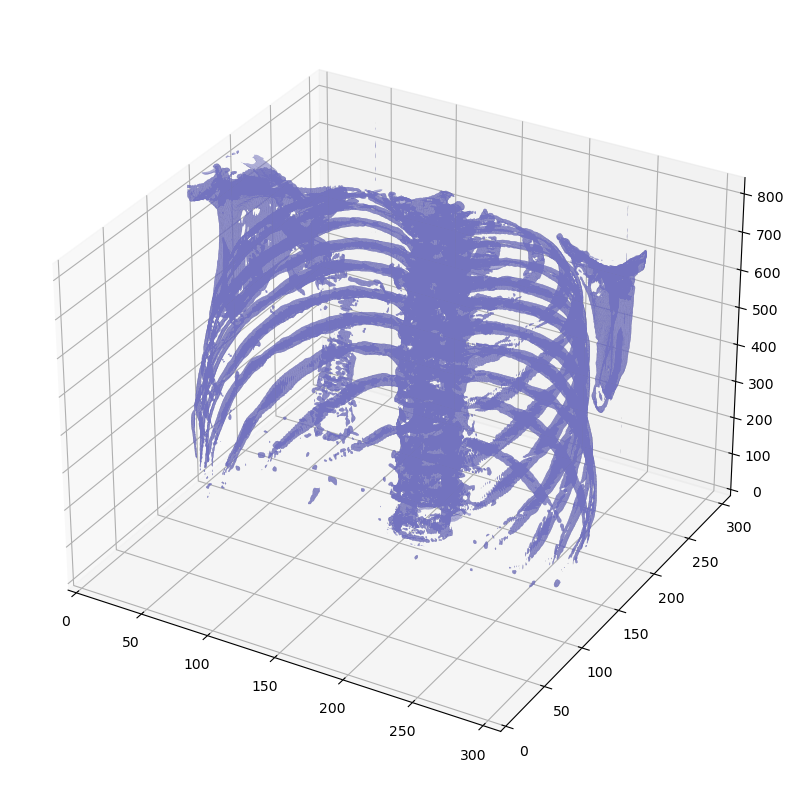

In [21]:
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt

def plot_3d(image, threshold=-300):
    # Position the scan upright,
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2, 1, 0)

    # Marching cubes algorithm
    verts, faces, normals, values = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

# Print rib cage
plot_3d(pix_resampled, 400)

In [22]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

In [23]:
def segment_lung_mask(image, fill_lung_structures=True):

    # not actually binary, but 1 and 2.
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)

    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air
    #   around the person in half
    background_label = labels[0,0,0]

    #Fill the air around the person
    binary_image[background_label == labels] = 2


    # Method of filling the lung structures (that is superior to something like
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)

            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1


    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1

    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0

    return binary_image

In [24]:
segmented_lungs = segment_lung_mask(pix_resampled, False)
segmented_lungs_fill = segment_lung_mask(pix_resampled, True)

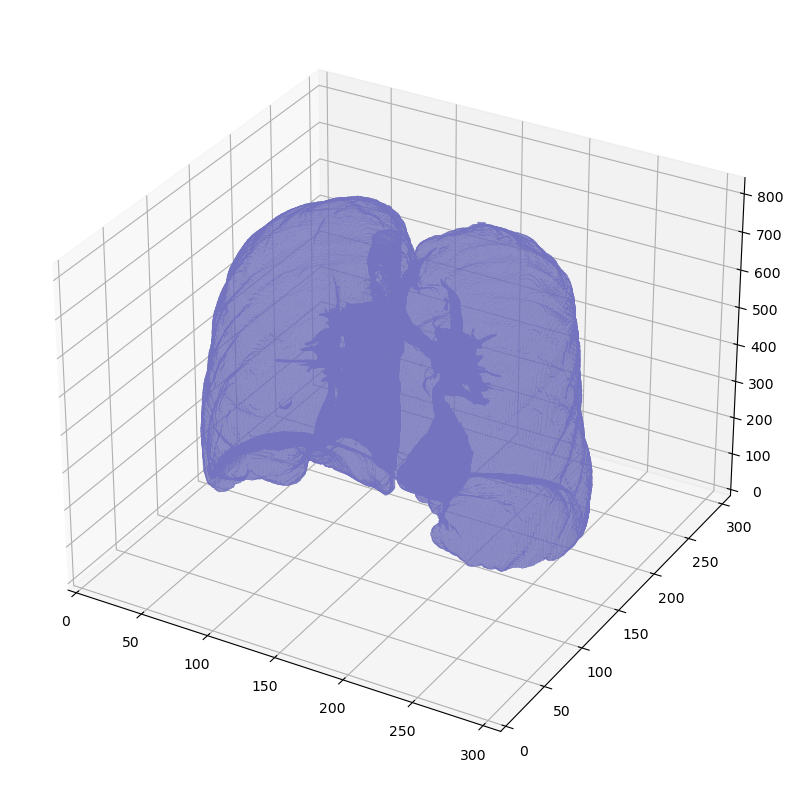

In [25]:
plot_3d(segmented_lungs_fill, 0)

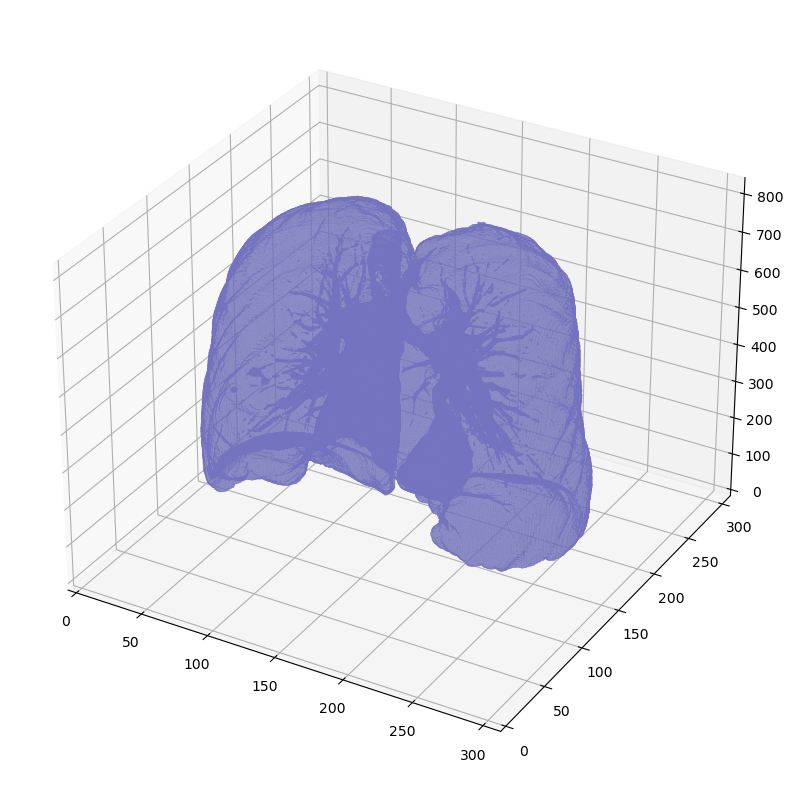

In [26]:
plot_3d(segmented_lungs, 0)

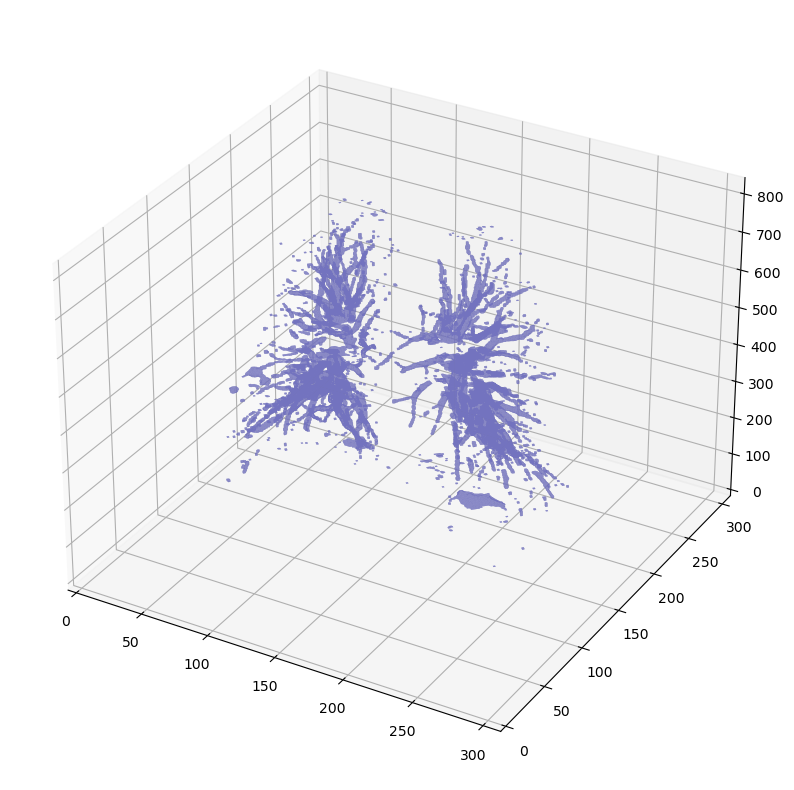

In [28]:
plot_3d(segmented_lungs_fill - segmented_lungs, 0)